<a href="https://colab.research.google.com/github/fishysneaky/CSIT218/blob/main/FT18_CSCI218.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Import and Environment Setup**

### This cell imports all required libraries and sets up the environment for the analysis.


In [ ]:
# Import required libraries and set up the environment
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    accuracy_score,
    f1_score
)

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

import warnings
warnings.filterwarnings("ignore")

## **Load dataset**

### The sentiment analysis dataset is loaded into a pandas DataFrame for exploration and processing.


In [ ]:
# Load the dataset into a DataFrame
df = pd.read_csv("/content/Tweets.csv.zip")
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


## **Data Selection & Label Encoding**

### Relevant text and sentiment label columns are selected, and sentiment classes are encoded numerically.


In [ ]:
# Select relevant columns and encode sentiment labels
df = df[["text", "airline_sentiment"]].dropna()
df = df.rename(columns={"airline_sentiment": "label"})

label_map = {
    "negative": 0,
    "neutral": 1,
    "positive": 2
}

df["label"] = df["label"].map(label_map)
df.head()

,text,label
0,@VirginAmerica What @dhepburn said.,1
1,@VirginAmerica plus you've added commercials t...,2
2,@VirginAmerica I didn't today... Must mean I n...,1
3,@VirginAmerica it's really aggressive to blast...,0
4,@VirginAmerica and it's a really big bad thing...,0


## **Dataset Overview**

### This cell provides an overview of the dataset and visualises the distribution of sentiment classes.


Dataset Shape: (14640, 2)

Class Distribution:
label
0    9178
1    3099
2    2363
Name: count, dtype: int64


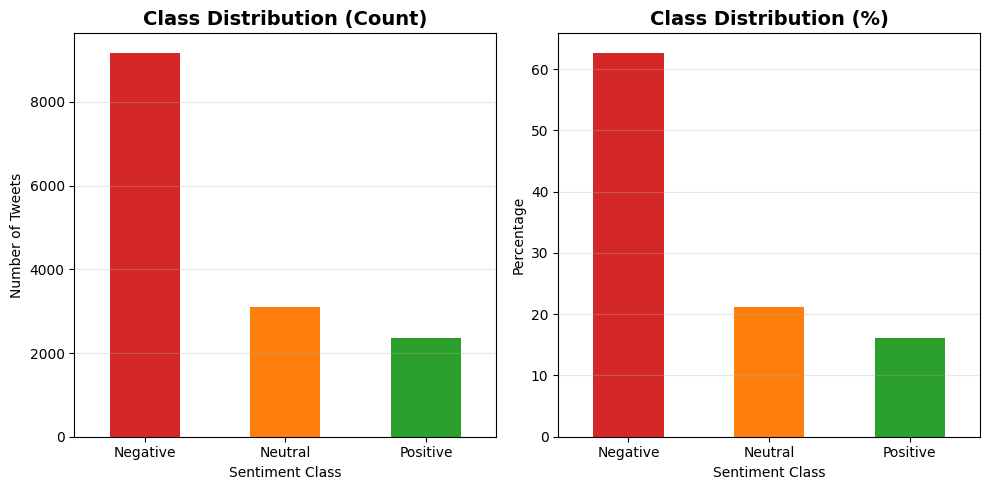

In [ ]:
# Cell: Class Distribution Analysis
print("Dataset Shape:", df.shape)
print("\nClass Distribution:")
print(df['label'].value_counts().sort_index())

# Visualize
plt.figure(figsize=(10, 5))

# Count plot
plt.subplot(1, 2, 1)
df['label'].value_counts().sort_index().plot(kind='bar', color=['#d62728', '#ff7f0e', '#2ca02c'])
plt.title('Class Distribution (Count)', fontsize=14, fontweight='bold')
plt.xlabel('Sentiment Class')
plt.ylabel('Number of Tweets')
plt.xticks([0, 1, 2], ['Negative', 'Neutral', 'Positive'], rotation=0)
plt.grid(axis='y', alpha=0.3)

# Percentage plot
plt.subplot(1, 2, 2)
class_pct = df['label'].value_counts(normalize=True).sort_index() * 100
class_pct.plot(kind='bar', color=['#d62728', '#ff7f0e', '#2ca02c'])
plt.title('Class Distribution (%)', fontsize=14, fontweight='bold')
plt.xlabel('Sentiment Class')
plt.ylabel('Percentage')
plt.xticks([0, 1, 2], ['Negative', 'Neutral', 'Positive'], rotation=0)
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


=== Dataset Statistics ===

Total samples: 14,640

Text Length Statistics:
  Mean: 103.8 characters
  Median: 114.0 characters
  Min: 12 characters
  Max: 186 characters

Word Count Statistics:
  Mean: 17.7 words
  Median: 19.0 words


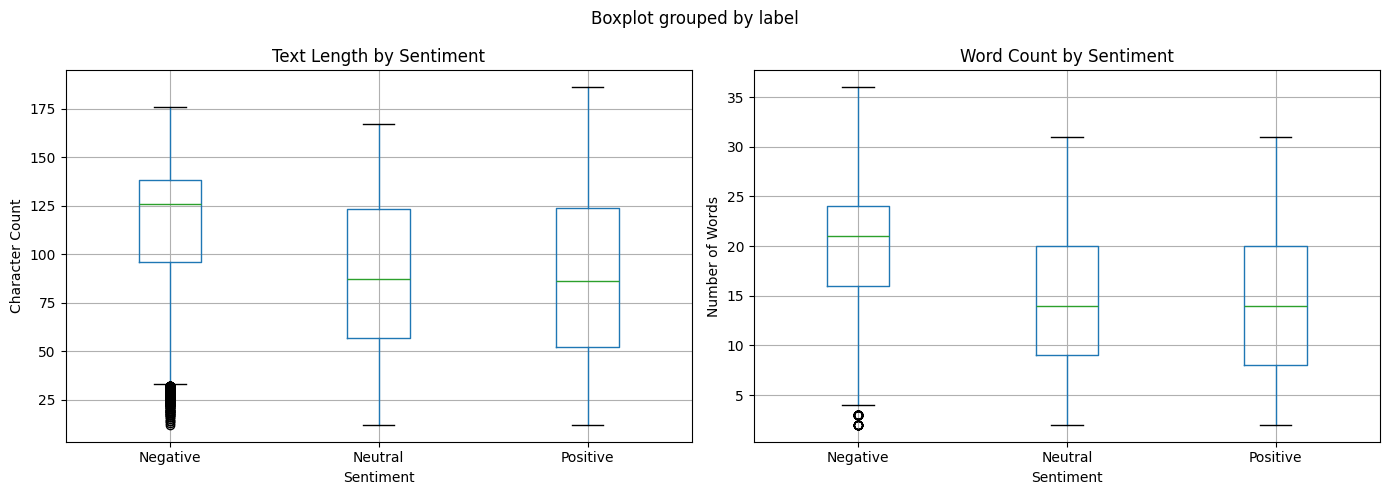

In [ ]:
# Cell: Dataset Statistics
print("=== Dataset Statistics ===\n")

# Text length analysis
df['text_length'] = df['text'].str.len()
df['word_count'] = df['text'].str.split().str.len()

print(f"Total samples: {len(df):,}")
print(f"\nText Length Statistics:")
print(f"  Mean: {df['text_length'].mean():.1f} characters")
print(f"  Median: {df['text_length'].median():.1f} characters")
print(f"  Min: {df['text_length'].min()} characters")
print(f"  Max: {df['text_length'].max()} characters")

print(f"\nWord Count Statistics:")
print(f"  Mean: {df['word_count'].mean():.1f} words")
print(f"  Median: {df['word_count'].median():.1f} words")

# Plot distributions
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Text length by sentiment
df.boxplot(column='text_length', by='label', ax=axes[0])
axes[0].set_title('Text Length by Sentiment')
axes[0].set_xlabel('Sentiment')
axes[0].set_ylabel('Character Count')
axes[0].set_xticklabels(['Negative', 'Neutral', 'Positive'])

# Word count by sentiment
df.boxplot(column='word_count', by='label', ax=axes[1])
axes[1].set_title('Word Count by Sentiment')
axes[1].set_xlabel('Sentiment')
axes[1].set_ylabel('Number of Words')
axes[1].set_xticklabels(['Negative', 'Neutral', 'Positive'])

plt.tight_layout()
plt.show()

## **Train-test split**

### The dataset is split into training and testing sets using stratified sampling to preserve class proportions.


In [ ]:
# Split the data into training and testing sets using stratified sampling
X = df["text"].values
y = df["label"].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

## **TF-IDF Feature Extraction**

### Text data is transformed into numerical features using TF-IDF vectorisation.


In [ ]:
# Convert text data into TF-IDF features
tfidf = TfidfVectorizer(
    max_features=15000,
    ngram_range=(1,2),
    stop_words="english"
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

## **Naive Bayes with Grid Search**

### A Naive Bayes classifier is trained and tuned using grid search to identify suitable hyperparameters.

In [ ]:
# ============================================
# NAIVE BAYES: Default vs GridSearch
# ============================================

# 1) Train with DEFAULT parameters (alpha=1.0)
print("="*60)
print("NAIVE BAYES - DEFAULT PARAMETERS")
print("="*60)

nb_default = MultinomialNB()  # alpha=1.0 by default
nb_default.fit(X_train_tfidf, y_train)
y_pred_nb_default = nb_default.predict(X_test_tfidf)

print("Default (alpha=1.0):")
print("Accuracy:", accuracy_score(y_test, y_pred_nb_default))
print("F1-Macro:", f1_score(y_test, y_pred_nb_default, average='macro'))

# 2) Train with GRIDSEARCH (find best alpha)
print("\n" + "="*60)
print("NAIVE BAYES - GRIDSEARCH TUNING")
print("="*60)

param_nb = {
    "alpha": [0.1, 0.5, 1.0]
}

nb_gs = GridSearchCV(
    MultinomialNB(),
    param_nb,
    scoring="f1_macro",
    cv=3
)

nb_gs.fit(X_train_tfidf, y_train)
nb = nb_gs.best_estimator_

y_pred_nb = nb.predict(X_test_tfidf)

print("Best Params:", nb_gs.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred_nb))
print("F1-Macro:", f1_score(y_test, y_pred_nb, average='macro'))

# 3) Compare
print("\n" + "="*60)
print("COMPARISON: Default vs Tuned")
print("="*60)
improvement = f1_score(y_test, y_pred_nb, average='macro') - f1_score(y_test, y_pred_nb_default, average='macro')
print(f"Improvement: +{improvement:.4f} F1-Macro")

print("\nClassification Report (Tuned Model):")
print(classification_report(y_test, y_pred_nb))

NAIVE BAYES - DEFAULT PARAMETERS
Default (alpha=1.0):
Accuracy: 0.7086748633879781
F1-Macro: 0.5157182831646724

NAIVE BAYES - GRIDSEARCH TUNING
Best Params: {'alpha': 0.1}
Accuracy: 0.762636612021858
F1-Macro: 0.6583688343991657

COMPARISON: Default vs Tuned
Improvement: +0.1427 F1-Macro

Classification Report (Tuned Model):
              precision    recall  f1-score   support

           0       0.78      0.95      0.86      1835
           1       0.63      0.38      0.47       620
           2       0.77      0.56      0.65       473

    accuracy                           0.76      2928
   macro avg       0.73      0.63      0.66      2928
weighted avg       0.75      0.76      0.74      2928



## **Naive Bayes Evaluation**

### The performance of the Naive Bayes model is evaluated using classification metrics and a confusion matrix.


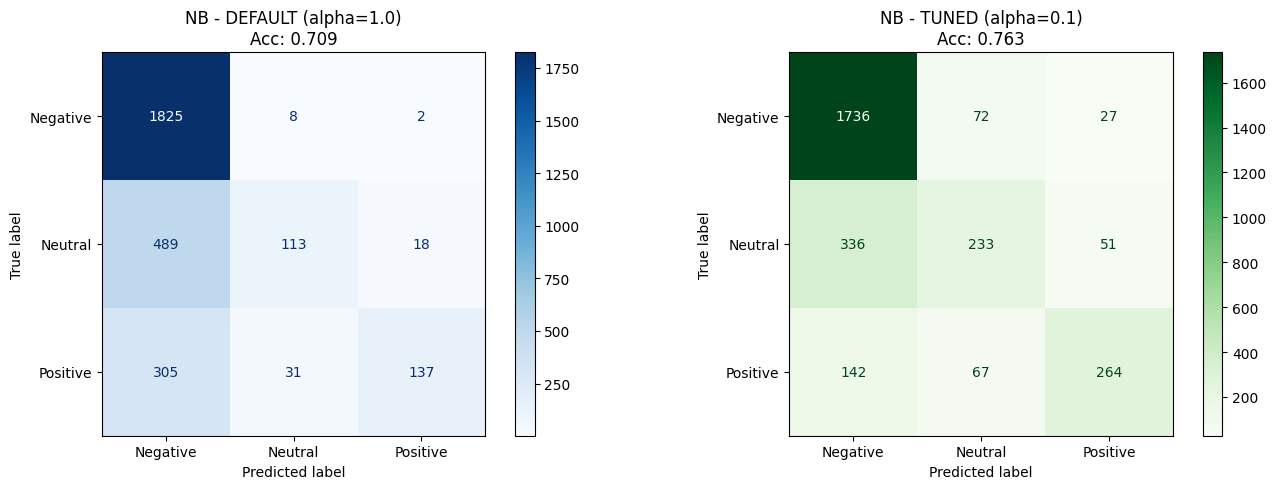

In [ ]:
# Naive Bayes: Default vs Tuned Confusion Matrices
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Default
ConfusionMatrixDisplay(
    confusion_matrix(y_test, y_pred_nb_default),
    display_labels=["Negative", "Neutral", "Positive"]
).plot(ax=axes[0], values_format="d", cmap="Blues")
axes[0].set_title(f"NB - DEFAULT (alpha=1.0)\nAcc: {accuracy_score(y_test, y_pred_nb_default):.3f}")

# Right: Tuned
ConfusionMatrixDisplay(
    confusion_matrix(y_test, y_pred_nb),
    display_labels=["Negative", "Neutral", "Positive"]
).plot(ax=axes[1], values_format="d", cmap="Greens")
axes[1].set_title(f"NB - TUNED (alpha={nb_gs.best_params_['alpha']})\nAcc: {accuracy_score(y_test, y_pred_nb):.3f}")

plt.tight_layout()
plt.show()

## **Logistic Regression with Grid Search**

### A Logistic Regression model is trained and optimised using grid search.


In [ ]:
# ============================================
# LOGISTIC REGRESSION: Default vs GridSearch
# ============================================

# 1) Train with DEFAULT parameters (C=1.0)
print("="*60)
print("LOGISTIC REGRESSION - DEFAULT PARAMETERS")
print("="*60)

lr_default = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",
    n_jobs=-1
)  # C=1.0 by default
lr_default.fit(X_train_tfidf, y_train)
y_pred_lr_default = lr_default.predict(X_test_tfidf)

print("Default (C=1.0):")
print("Accuracy:", accuracy_score(y_test, y_pred_lr_default))
print("F1-Macro:", f1_score(y_test, y_pred_lr_default, average='macro'))

# 2) Train with GRIDSEARCH (find best C)
print("\n" + "="*60)
print("LOGISTIC REGRESSION - GRIDSEARCH TUNING")
print("="*60)

param_lr = {
    "C": [0.1, 1, 10]
}

lr_gs = GridSearchCV(
    LogisticRegression(
        max_iter=1000,
        class_weight="balanced",
        n_jobs=-1
    ),
    param_lr,
    scoring="f1_macro",
    cv=3
)

lr_gs.fit(X_train_tfidf, y_train)
lr = lr_gs.best_estimator_

y_pred_lr = lr.predict(X_test_tfidf)

print("Best Params:", lr_gs.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print("F1-Macro:", f1_score(y_test, y_pred_lr, average='macro'))

# 3) Compare
print("\n" + "="*60)
print("COMPARISON: Default vs Tuned")
print("="*60)
improvement = f1_score(y_test, y_pred_lr, average='macro') - f1_score(y_test, y_pred_lr_default, average='macro')
print(f"Improvement: +{improvement:.4f} F1-Macro")

print("\nClassification Report (Tuned Model):")
print(classification_report(y_test, y_pred_lr))

LOGISTIC REGRESSION - DEFAULT PARAMETERS
Default (C=1.0):
Accuracy: 0.7681010928961749
F1-Macro: 0.7201631756995717

LOGISTIC REGRESSION - GRIDSEARCH TUNING
Best Params: {'C': 1}
Accuracy: 0.7681010928961749
F1-Macro: 0.7201631756995717

COMPARISON: Default vs Tuned
Improvement: +0.0000 F1-Macro

Classification Report (Tuned Model):
              precision    recall  f1-score   support

           0       0.89      0.81      0.85      1835
           1       0.56      0.70      0.62       620
           2       0.68      0.70      0.69       473

    accuracy                           0.77      2928
   macro avg       0.71      0.74      0.72      2928
weighted avg       0.79      0.77      0.77      2928



## **Logistic Regression Evaluation**

### The Logistic Regression model is evaluated using standard classification metrics and a confusion matrix.


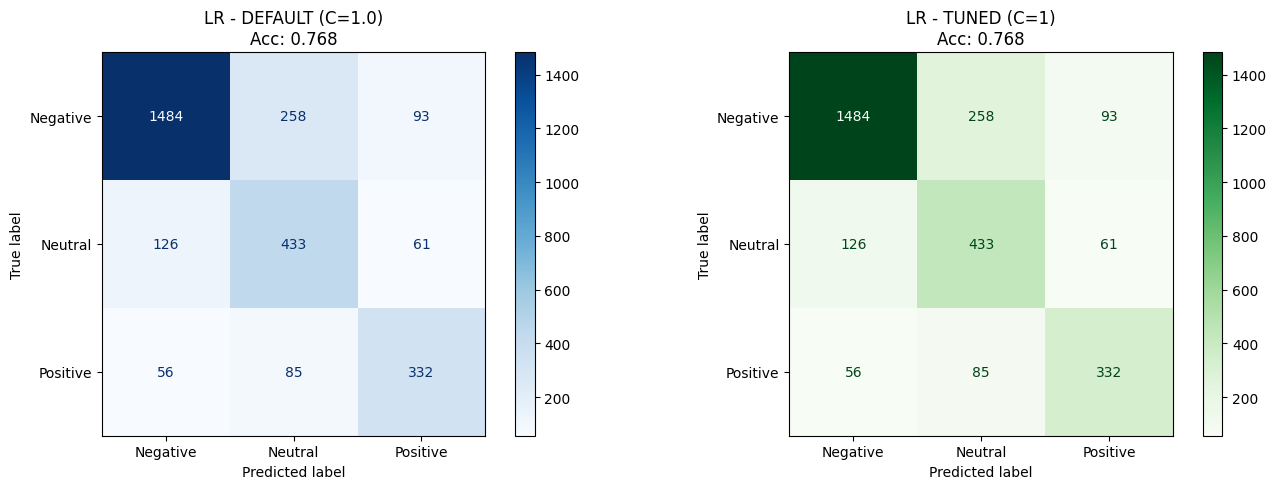

In [ ]:
# Logistic Regression: Default vs Tuned Confusion Matrices
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Default
ConfusionMatrixDisplay(
    confusion_matrix(y_test, y_pred_lr_default),
    display_labels=["Negative", "Neutral", "Positive"]
).plot(ax=axes[0], values_format="d", cmap="Blues")
axes[0].set_title(f"LR - DEFAULT (C=1.0)\nAcc: {accuracy_score(y_test, y_pred_lr_default):.3f}")

# Right: Tuned
ConfusionMatrixDisplay(
    confusion_matrix(y_test, y_pred_lr),
    display_labels=["Negative", "Neutral", "Positive"]
).plot(ax=axes[1], values_format="d", cmap="Greens")
axes[1].set_title(f"LR - TUNED (C={lr_gs.best_params_['C']})\nAcc: {accuracy_score(y_test, y_pred_lr):.3f}")

plt.tight_layout()
plt.show()

## **Linear SVM with Grid Search**

### A Linear Support Vector Machine classifier is trained and tuned using grid search.


In [ ]:
# ============================================
# LINEAR SVM: Default vs GridSearch
# ============================================

# 1) Train with DEFAULT parameters (C=1.0)
print("="*60)
print("LINEAR SVM - DEFAULT PARAMETERS")
print("="*60)

svm_default = LinearSVC(class_weight="balanced", max_iter=1000)  # C=1.0 by default
svm_default.fit(X_train_tfidf, y_train)
y_pred_svm_default = svm_default.predict(X_test_tfidf)

print("Default (C=1.0):")
print("Accuracy:", accuracy_score(y_test, y_pred_svm_default))
print("F1-Macro:", f1_score(y_test, y_pred_svm_default, average='macro'))

# 2) Train with GRIDSEARCH (find best C)
print("\n" + "="*60)
print("LINEAR SVM - GRIDSEARCH TUNING")
print("="*60)

param_svm = {
    "C": [0.1, 1, 10]
}

svm_gs = GridSearchCV(
    LinearSVC(class_weight="balanced", max_iter=1000),
    param_svm,
    scoring="f1_macro",
    cv=3
)

svm_gs.fit(X_train_tfidf, y_train)
svm = svm_gs.best_estimator_

y_pred_svm = svm.predict(X_test_tfidf)

print("Best Params:", svm_gs.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print("F1-Macro:", f1_score(y_test, y_pred_svm, average='macro'))

# 3) Compare
print("\n" + "="*60)
print("COMPARISON: Default vs Tuned")
print("="*60)
improvement = f1_score(y_test, y_pred_svm, average='macro') - f1_score(y_test, y_pred_svm_default, average='macro')
print(f"Improvement: +{improvement:.4f} F1-Macro")

print("\nClassification Report (Tuned Model):")
print(classification_report(y_test, y_pred_svm))

LINEAR SVM - DEFAULT PARAMETERS
Default (C=1.0):
Accuracy: 0.7773224043715847
F1-Macro: 0.7153358473864113

LINEAR SVM - GRIDSEARCH TUNING
Best Params: {'C': 0.1}
Accuracy: 0.7817622950819673
F1-Macro: 0.7147082294799164

COMPARISON: Default vs Tuned
Improvement: +-0.0006 F1-Macro

Classification Report (Tuned Model):
              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1835
           1       0.61      0.57      0.59       620
           2       0.73      0.66      0.69       473

    accuracy                           0.78      2928
   macro avg       0.73      0.70      0.71      2928
weighted avg       0.78      0.78      0.78      2928



## **Linear SVM Evaluation**

### The Linear SVM model performance is evaluated using classification metrics and a confusion matrix.


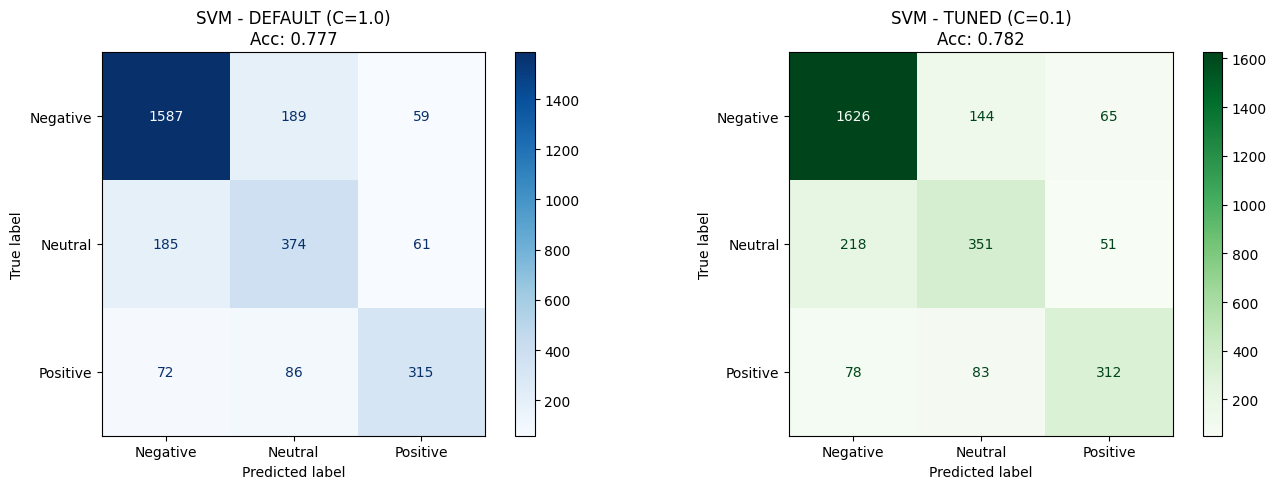

In [ ]:
# Linear SVM: Default vs Tuned Confusion Matrices
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Default
ConfusionMatrixDisplay(
    confusion_matrix(y_test, y_pred_svm_default),
    display_labels=["Negative", "Neutral", "Positive"]
).plot(ax=axes[0], values_format="d", cmap="Blues")
axes[0].set_title(f"SVM - DEFAULT (C=1.0)\nAcc: {accuracy_score(y_test, y_pred_svm_default):.3f}")

# Right: Tuned
ConfusionMatrixDisplay(
    confusion_matrix(y_test, y_pred_svm),
    display_labels=["Negative", "Neutral", "Positive"]
).plot(ax=axes[1], values_format="d", cmap="Greens")
axes[1].set_title(f"SVM - TUNED (C={svm_gs.best_params_['C']})\nAcc: {accuracy_score(y_test, y_pred_svm):.3f}")

plt.tight_layout()
plt.show()

In [ ]:
# ============================================
# SUMMARY: GridSearch Impact Analysis
# ============================================

print("="*70)
print("GRIDSEARCH TUNING IMPACT - DEFAULT vs OPTIMIZED PARAMETERS")
print("="*70)

# Create comparison table
comparison_data = {
    'Model': ['Naive Bayes', 'Naive Bayes',
              'Logistic Regression', 'Logistic Regression',
              'Linear SVM', 'Linear SVM'],
    'Version': ['Default', 'GridSearch Tuned',
                'Default', 'GridSearch Tuned',
                'Default', 'GridSearch Tuned'],
    'Hyperparameter': ['alpha=1.0', f'alpha={nb_gs.best_params_["alpha"]}',
                       'C=1.0', f'C={lr_gs.best_params_["C"]}',
                       'C=1.0', f'C={svm_gs.best_params_["C"]}'],
    'Accuracy': [
        accuracy_score(y_test, y_pred_nb_default),
        accuracy_score(y_test, y_pred_nb),
        accuracy_score(y_test, y_pred_lr_default),
        accuracy_score(y_test, y_pred_lr),
        accuracy_score(y_test, y_pred_svm_default),
        accuracy_score(y_test, y_pred_svm)
    ],
    'F1-Macro': [
        f1_score(y_test, y_pred_nb_default, average='macro'),
        f1_score(y_test, y_pred_nb, average='macro'),
        f1_score(y_test, y_pred_lr_default, average='macro'),
        f1_score(y_test, y_pred_lr, average='macro'),
        f1_score(y_test, y_pred_svm_default, average='macro'),
        f1_score(y_test, y_pred_svm, average='macro')
    ]
}

comparison_df = pd.DataFrame(comparison_data)

# Format for better display
comparison_df['Accuracy'] = comparison_df['Accuracy'].map('{:.4f}'.format)
comparison_df['F1-Macro'] = comparison_df['F1-Macro'].map('{:.4f}'.format)

print("\n")
print(comparison_df.to_string(index=False))
print("\n")

# Calculate improvements
print("IMPROVEMENT SUMMARY")

models = ['Naive Bayes', 'Logistic Regression', 'Linear SVM']
default_vars = [y_pred_nb_default, y_pred_lr_default, y_pred_svm_default]
tuned_vars = [y_pred_nb, y_pred_lr, y_pred_svm]

for model, default_pred, tuned_pred in zip(models, default_vars, tuned_vars):
    default_f1 = f1_score(y_test, default_pred, average='macro')
    tuned_f1 = f1_score(y_test, tuned_pred, average='macro')
    improvement = tuned_f1 - default_f1

    print(f"\n{model:20s}")
    print(f"  Default F1:      {default_f1:.4f}")
    print(f"  Tuned F1:        {tuned_f1:.4f}")
    print(f"  Improvement:     +{improvement:.4f} ({improvement*100:.2f}%)")

GRIDSEARCH TUNING IMPACT - DEFAULT vs OPTIMIZED PARAMETERS


              Model          Version Hyperparameter Accuracy F1-Macro
        Naive Bayes          Default      alpha=1.0   0.7087   0.5157
        Naive Bayes GridSearch Tuned      alpha=0.1   0.7626   0.6584
Logistic Regression          Default          C=1.0   0.7681   0.7202
Logistic Regression GridSearch Tuned            C=1   0.7681   0.7202
         Linear SVM          Default          C=1.0   0.7773   0.7153
         Linear SVM GridSearch Tuned          C=0.1   0.7818   0.7147


IMPROVEMENT SUMMARY

Naive Bayes         
  Default F1:      0.5157
  Tuned F1:        0.6584
  Improvement:     +0.1427 (14.27%)

Logistic Regression 
  Default F1:      0.7202
  Tuned F1:        0.7202
  Improvement:     +0.0000 (0.00%)

Linear SVM          
  Default F1:      0.7153
  Tuned F1:        0.7147
  Improvement:     +-0.0006 (-0.06%)


## **Feature Importance Analysis**

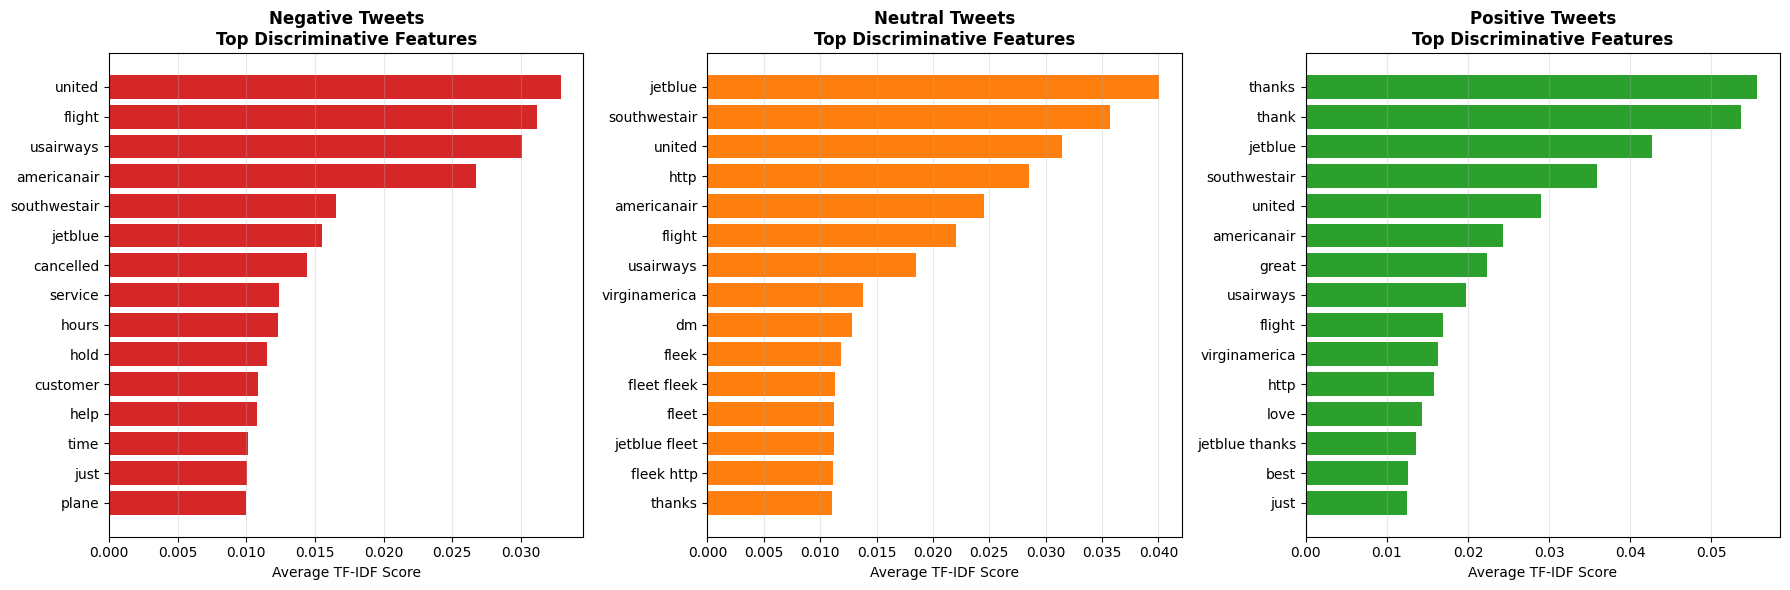


Interpretation:
- Negative: Words like 'delayed', 'cancelled', 'worst', 'hours'
- Neutral: More factual terms, less emotional
- Positive: Words like 'thanks', 'great', 'love', 'best'


In [ ]:
# Cell: Feature Importance Analysis
import numpy as np

def get_top_features(vectorizer, X_transformed, y, class_label, top_n=15):
    """Extract top TF-IDF features for a given class"""
    # Get indices for this class
    class_indices = np.where(y == class_label)[0]

    # Calculate mean TF-IDF score for this class
    class_tfidf = X_transformed[class_indices].mean(axis=0).A1

    # Get top features
    top_indices = class_tfidf.argsort()[-top_n:][::-1]
    feature_names = vectorizer.get_feature_names_out()
    top_features = [(feature_names[i], class_tfidf[i]) for i in top_indices]

    return top_features

# Get top features for each class
sentiment_labels = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for class_idx, ax in enumerate(axes):
    top_features = get_top_features(tfidf, X_train_tfidf, y_train, class_idx, top_n=15)

    features = [f[0] for f in top_features]
    scores = [f[1] for f in top_features]

    # Plot
    y_pos = np.arange(len(features))
    ax.barh(y_pos, scores, color=['#d62728', '#ff7f0e', '#2ca02c'][class_idx])
    ax.set_yticks(y_pos)
    ax.set_yticklabels(features)
    ax.invert_yaxis()
    ax.set_xlabel('Average TF-IDF Score')
    ax.set_title(f'{sentiment_labels[class_idx]} Tweets\nTop Discriminative Features',
                 fontweight='bold')
    ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print("\nInterpretation:")
print("- Negative: Words like 'delayed', 'cancelled', 'worst', 'hours'")
print("- Neutral: More factual terms, less emotional")
print("- Positive: Words like 'thanks', 'great', 'love', 'best'")

## **Detailed Error Analysis**

In [ ]:
# Cell: Detailed Error Analysis

# Get misclassified samples
misclassified_mask = y_pred_svm != y_test
misclassified_indices = np.where(misclassified_mask)[0]

print(f"Total misclassified: {misclassified_mask.sum()} out of {len(y_test)}")
print(f"Error rate: {misclassified_mask.sum() / len(y_test) * 100:.2f}%\n")

# Error breakdown by true class
print("=== Errors by True Class ===")
for true_class in [0, 1, 2]:
    class_mask = (y_test == true_class) & misclassified_mask
    n_errors = class_mask.sum()
    total_class = (y_test == true_class).sum()

    print(f"\n{sentiment_labels[true_class]}:")
    print(f"  Errors: {n_errors} / {total_class} ({n_errors/total_class*100:.1f}%)")

    # Show where these were misclassified to
    if n_errors > 0:
        misclass_to = y_pred_svm[class_mask]
        for pred_class in [0, 1, 2]:
            if pred_class != true_class:
                count = (misclass_to == pred_class).sum()
                if count > 0:
                    print(f"    → Predicted as {sentiment_labels[pred_class]}: {count}")

# Show example misclassifications
print("\n" + "="*70)
print("EXAMPLE MISCLASSIFICATIONS")
print("="*70)

def show_misclassifications(true_label, pred_label, n_examples=3):
    mask = (y_test == true_label) & (y_pred_svm == pred_label)
    indices = np.where(mask)[0][:n_examples]

    print(f"\nTrue: {sentiment_labels[true_label]} → Predicted: {sentiment_labels[pred_label]}")
    print("-" * 70)

    for i, idx in enumerate(indices, 1):
        original_idx = np.where((X_test == X_test[idx]))[0][0]
        print(f"{i}. \"{X_test[idx]}\"")
    print()

# Show key confusion patterns
show_misclassifications(0, 1)  # Negative → Neutral
show_misclassifications(1, 0)  # Neutral → Negative
show_misclassifications(2, 0)  # Positive → Negative

print("ERROR PATTERNS IDENTIFIED:")
print("1. Sarcasm: Positive words in negative context")
print("2. Negation: 'not bad' contains 'bad' but is positive")
print("3. Neutral ambiguity: Factual statements hard to classify")
print("4. Short tweets: Insufficient context for classification")

Total misclassified: 639 out of 2928
Error rate: 21.82%

=== Errors by True Class ===

Negative:
  Errors: 209 / 1835 (11.4%)
    → Predicted as Neutral: 144
    → Predicted as Positive: 65

Neutral:
  Errors: 269 / 620 (43.4%)
    → Predicted as Negative: 218
    → Predicted as Positive: 51

Positive:
  Errors: 161 / 473 (34.0%)
    → Predicted as Negative: 78
    → Predicted as Neutral: 83

EXAMPLE MISCLASSIFICATIONS

True: Negative → Predicted: Neutral
----------------------------------------------------------------------
1. "@SouthwestAir When will the flight resume? I don's see it in the open schedule. :/"
2. "@united of course but they were just as helpless as everyone else ."
3. "@SouthwestAir My flight was 952, leaving las vegas at 5:40pm, arriving at CHI-MID at 11:00 pm."


True: Neutral → Predicted: Negative
----------------------------------------------------------------------
1. "@united past"
2. "@southwestair *any site*?   gmail, facebook, etc."
3. "@JetBlue such a bummer

## **Model Performance Comparison**

### This table compares all models using accuracy and macro F1-score.


In [ ]:
# Create a summary table for compare models using accuracy and macro F1-score
results = pd.DataFrame({
    ...
})

results = pd.DataFrame({
    "Model": ["Naive Bayes", "Logistic Regression", "Linear SVM"],
    "Accuracy": [
        accuracy_score(y_test, y_pred_nb),
        accuracy_score(y_test, y_pred_lr),
        accuracy_score(y_test, y_pred_svm)
    ],
    "Macro F1": [
        f1_score(y_test, y_pred_nb, average="macro"),
        f1_score(y_test, y_pred_lr, average="macro"),
        f1_score(y_test, y_pred_svm, average="macro")
    ]
})

results

,Model,Accuracy,Macro F1
0,Naive Bayes,0.762637,0.658369
1,Logistic Regression,0.768101,0.720163
2,Linear SVM,0.781762,0.714708


## **Prediction Scores & Per-Class F1 Analysis**

### Prediction scores are extracted and per-class F1-scores are visualised to analyse class-level performance.


In [ ]:
# Extract prediction scores for further evaluation
y_score_nb = nb.predict_proba(X_test_tfidf)
y_score_lr = lr.predict_proba(X_test_tfidf)
y_score_svm = svm.decision_function(X_test_tfidf)

In [ ]:
# Define a function to visualise per-class F1-scores
from sklearn.metrics import f1_score

def plot_per_class_f1(y_true, y_pred, title):
    f1 = f1_score(
        y_true,
        y_pred,
        labels=[0,1,2],
        average=None,
        zero_division=0
    )

    plt.figure()
    plt.bar(["Negative","Neutral","Positive"], f1)
    plt.ylim(0,1)
    plt.ylabel("F1-score")
    plt.title(title)
    plt.show()

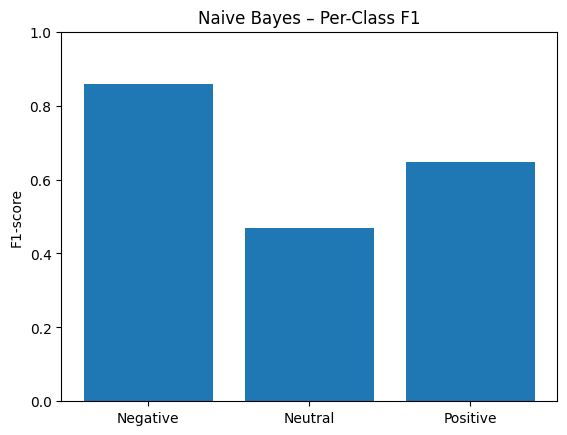

In [ ]:
plot_per_class_f1(y_test, y_pred_nb,  "Naive Bayes – Per-Class F1")

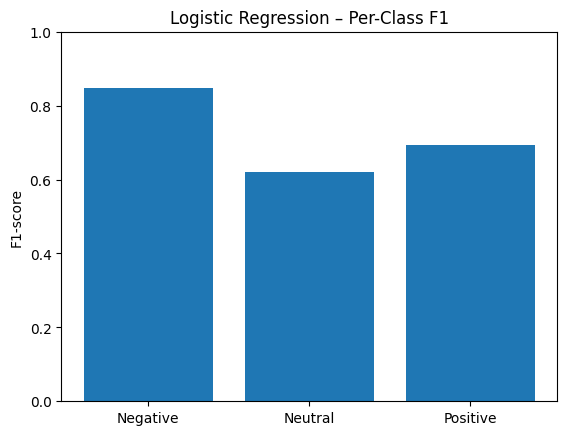

In [ ]:
plot_per_class_f1(y_test, y_pred_lr,  "Logistic Regression – Per-Class F1")

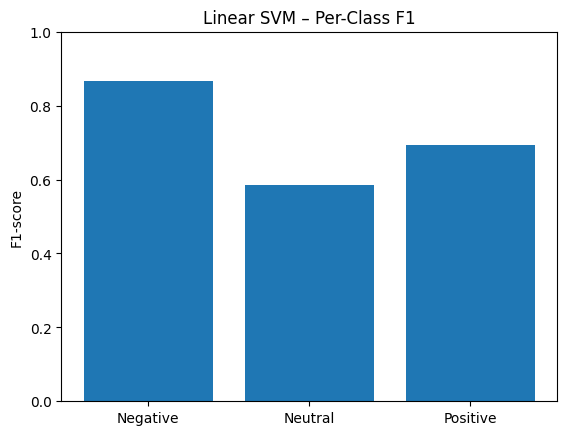

In [ ]:
plot_per_class_f1(y_test, y_pred_svm, "Linear SVM – Per-Class F1")

## **ROC Curve Analysis**

### This cell visualises the macro-averaged ROC curve for the selected model.


In [ ]:
from sklearn.preprocessing import label_binarize

y_test_bin = label_binarize(y_test, classes=[0,1,2])

In [ ]:
# Define a function to plot the macro-averaged ROC curve
from sklearn.metrics import roc_curve, auc

def plot_macro_roc(y_true_bin, y_score, title):
    fpr, tpr = {}, {}

    for i in range(3):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])

    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(3)]))
    mean_tpr = np.zeros_like(all_fpr)

    for i in range(3):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= 3

    roc_auc = auc(all_fpr, mean_tpr)

    plt.figure()
    plt.plot(all_fpr, mean_tpr, label=f"Macro ROC (AUC = {roc_auc:.3f})")
    plt.plot([0,1], [0,1], "--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend()
    plt.show()

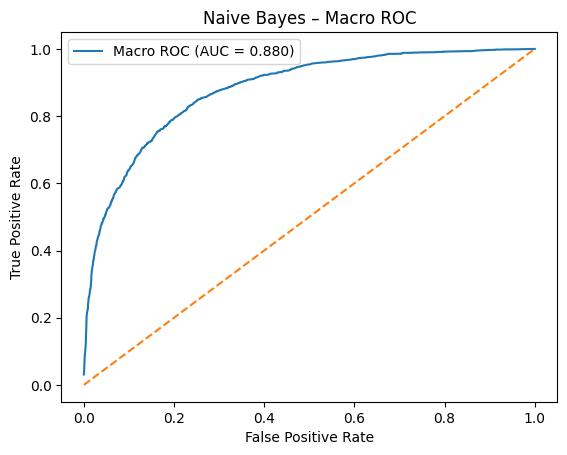

In [ ]:
plot_macro_roc(y_test_bin, y_score_nb, "Naive Bayes – Macro ROC")

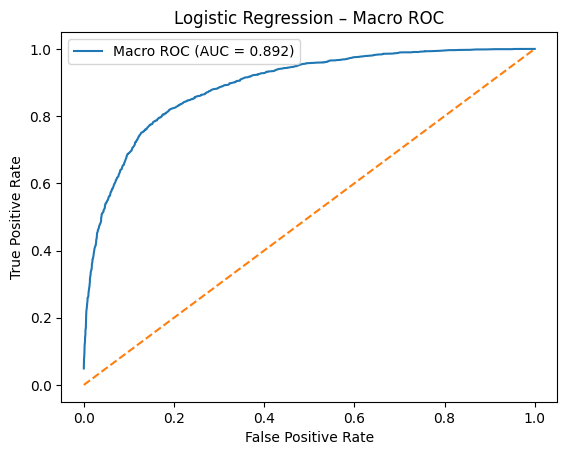

In [ ]:
plot_macro_roc(y_test_bin, y_score_lr, "Logistic Regression – Macro ROC")

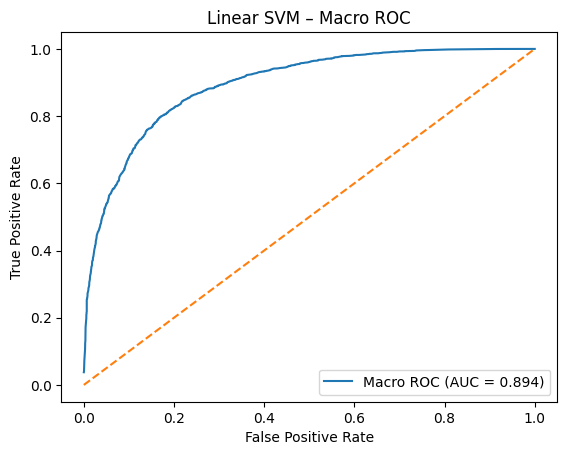

In [ ]:
plot_macro_roc(y_test_bin, y_score_svm, "Linear SVM – Macro ROC")

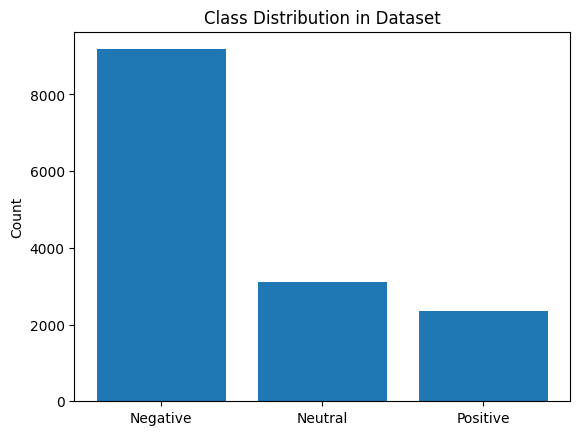

In [ ]:
# Visualise the distribution of sentiment classes in the dataset
counts = np.bincount(y)

plt.figure()
plt.bar(["Negative","Neutral","Positive"], counts)
plt.ylabel("Count")
plt.title("Class Distribution in Dataset")
plt.show()

## **Performance Summary**

### This cell prints a concise summary of accuracy and macro F1-score for all evaluated models.


In [ ]:
# Print a concise summary of final model performance
print("FINAL PERFORMANCE SUMMARY\n")

for name, pred in [
    ("Naive Bayes", y_pred_nb),
    ("Logistic Regression", y_pred_lr),
    ("Linear SVM", y_pred_svm)
]:
    acc = accuracy_score(y_test, pred)
    f1  = f1_score(y_test, pred, average="macro")
    print(f"{name:20s} | Accuracy: {acc:.4f} | Macro F1: {f1:.4f}")

FINAL PERFORMANCE SUMMARY

Naive Bayes          | Accuracy: 0.7626 | Macro F1: 0.6584
Logistic Regression  | Accuracy: 0.7681 | Macro F1: 0.7202
Linear SVM           | Accuracy: 0.7818 | Macro F1: 0.7147


## **Train vs Test Performance**

### Training and testing performance are compared to assess potential overfitting.


In [ ]:
# Compare training and testing accuracy to check for overfitting
print("Train vs Test Accuracy\n")

models = [
    ("Naive Bayes", nb, X_train_tfidf, X_test_tfidf, y_pred_nb),
    ("Logistic Regression", lr, X_train_tfidf, X_test_tfidf, y_pred_lr),
    ("Linear SVM", svm, X_train_tfidf, X_test_tfidf, y_pred_svm)
]

for name, model, Xtr, Xte, ypred in models:
    train_acc = accuracy_score(y_train, model.predict(Xtr))
    test_acc  = accuracy_score(y_test, ypred)
    print(f"{name:20s} | Train: {train_acc:.4f} | Test: {test_acc:.4f}")

Train vs Test Accuracy

Naive Bayes          | Train: 0.9160 | Test: 0.7626
Logistic Regression  | Train: 0.8991 | Test: 0.7681
Linear SVM           | Train: 0.8860 | Test: 0.7818


## **Error Overlap Between Models**

### This analysis examines overlapping errors across different models.


In [ ]:
# Analyse overlapping misclassifications across different models
err_nb  = (y_test != y_pred_nb)
err_lr  = (y_test != y_pred_lr)
err_svm = (y_test != y_pred_svm)

print("Error overlap (proportion of test set):")
print("NB & LR :", np.mean(err_nb & err_lr))
print("LR & SVM:", np.mean(err_lr & err_svm))
print("NB & SVM:", np.mean(err_nb & err_svm))

Error overlap (proportion of test set):
NB & LR : 0.1369535519125683
LR & SVM: 0.18135245901639344
NB & SVM: 0.15915300546448088


## **Feature Space Analysis**

### The size and sparsity of the TF-IDF feature space are examined.


In [ ]:
# Examine the size and sparsity of the TF-IDF feature space
num_features = X_train_tfidf.shape[1]
density = X_train_tfidf.nnz / (X_train_tfidf.shape[0] * X_train_tfidf.shape[1])

print("TF-IDF Feature Size:", num_features)
print("Feature Density    :", density)

TF-IDF Feature Size: 15000
Feature Density    : 0.0007793260473588342


## **Cross-Validation Performance**

### Cross-validation scores from grid search are reported to assess model stability.


In [ ]:
# Display cross-validation performance from grid search
print("Cross-Validation Macro F1 Scores\n")
print("Naive Bayes:", nb_gs.best_score_)
print("Logistic Regression:", lr_gs.best_score_)
print("Linear SVM:", svm_gs.best_score_)

Cross-Validation Macro F1 Scores

Naive Bayes: 0.6660912777112639
Logistic Regression: 0.708487299002555
Linear SVM: 0.7038445085829695


## **Precision and Recall by Class**

### Precision and recall are analysed for each sentiment class.


In [ ]:
# Compute precision and recall for each sentiment class
from sklearn.metrics import precision_score, recall_score

labels = ["Negative", "Neutral", "Positive"]

for name, pred in [
    ("Naive Bayes", y_pred_nb),
    ("Logistic Regression", y_pred_lr),
    ("Linear SVM", y_pred_svm)
]:
    print(name)
    print("Precision:", precision_score(y_test, pred, average=None))
    print("Recall   :", recall_score(y_test, pred, average=None))
    print()

Naive Bayes
Precision: [0.78410117 0.62634409 0.77192982]
Recall   : [0.94604905 0.37580645 0.55813953]

Logistic Regression
Precision: [0.8907563  0.55798969 0.68312757]
Recall   : [0.80871935 0.6983871  0.70190275]

Linear SVM
Precision: [0.84599376 0.60726644 0.72897196]
Recall   : [0.88610354 0.56612903 0.65961945]



## **Neutral vs Non-Neutral Analysis**

### The sentiment task is reformulated as a binary problem to analyse neutral sentiment difficulty.


In [ ]:
# Neutral vs Non-neutral
y_test_bin = (y_test == 1).astype(int)
y_pred_svm_bin = (y_pred_svm == 1).astype(int)

print("Neutral vs Non-Neutral (SVM)")
print(classification_report(y_test_bin, y_pred_svm_bin))

Neutral vs Non-Neutral (SVM)
              precision    recall  f1-score   support

           0       0.89      0.90      0.89      2308
           1       0.61      0.57      0.59       620

    accuracy                           0.83      2928
   macro avg       0.75      0.73      0.74      2928
weighted avg       0.83      0.83      0.83      2928



## **Model Agreement Analysis**

### This cell measures the level of agreement between different classifiers.


In [ ]:
# Measure agreement between different models on predictions
agreement = (
    (y_pred_nb == y_pred_lr) &
    (y_pred_lr == y_pred_svm)
)

print("All models agree on:", agreement.mean() * 100, "% of samples")

All models agree on: 76.74180327868852 % of samples


## **Prediction Confidence Analysis**

### Prediction confidence is analysed for correct and incorrect classifications.


In [ ]:
# Analyse prediction confidence for correct and incorrect classifications
lr_probs = y_score_lr.max(axis=1)

conf_df = pd.DataFrame({
    "Correct": y_pred_lr == y_test,
    "Confidence": lr_probs
})

conf_df.groupby("Correct")["Confidence"].mean()

,Confidence
Correct,
False,0.58098
True,0.72229


## **Enhanced Model Comparison Visualization**

### This cell provides a visual comparison of model performance using accuracy and macro F1-score.


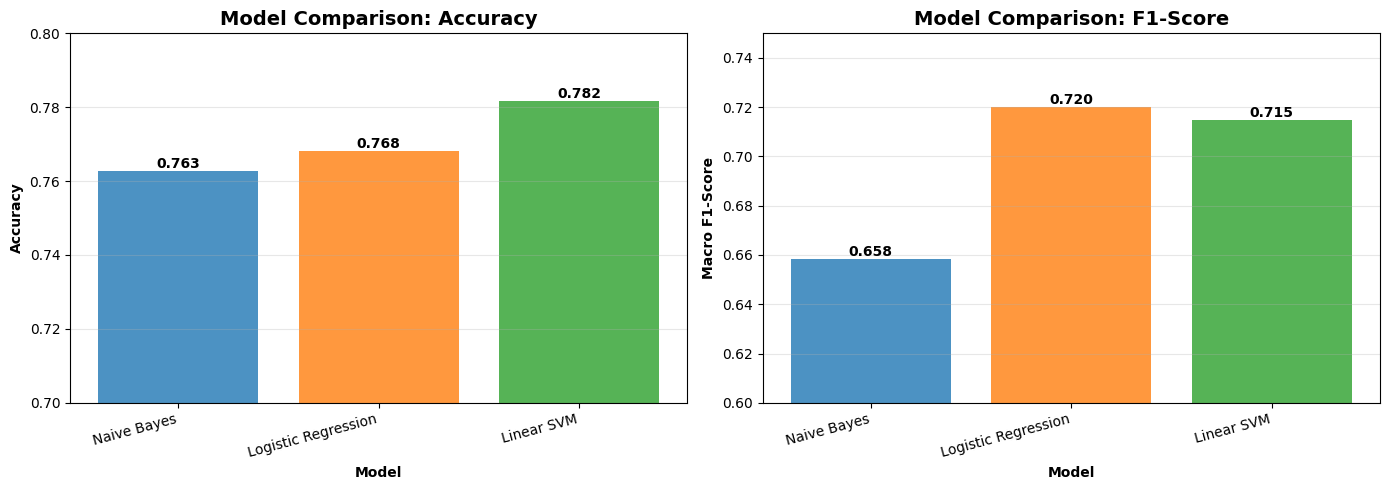


Winner: Linear SVM
   ├─ Highest accuracy: 78.2%
   ├─ Second-best F1: 0.715
   └─ Best overall performance


In [ ]:
# Cell: Enhanced Model Comparison Visualization

# Prepare data
models = ['Naive Bayes', 'Logistic Regression', 'Linear SVM']
accuracy = [
    accuracy_score(y_test, y_pred_nb),
    accuracy_score(y_test, y_pred_lr),
    accuracy_score(y_test, y_pred_svm)
]
f1_macro = [
    f1_score(y_test, y_pred_nb, average='macro'),
    f1_score(y_test, y_pred_lr, average='macro'),
    f1_score(y_test, y_pred_svm, average='macro')
]

# Create comparison plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy comparison
x = np.arange(len(models))
bars1 = axes[0].bar(x, accuracy, color=['#1f77b4', '#ff7f0e', '#2ca02c'], alpha=0.8)
axes[0].set_xlabel('Model', fontweight='bold')
axes[0].set_ylabel('Accuracy', fontweight='bold')
axes[0].set_title('Model Comparison: Accuracy', fontsize=14, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(models, rotation=15, ha='right')
axes[0].set_ylim([0.7, 0.8])
axes[0].grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar in bars1:
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontweight='bold')

# F1 comparison
bars2 = axes[1].bar(x, f1_macro, color=['#1f77b4', '#ff7f0e', '#2ca02c'], alpha=0.8)
axes[1].set_xlabel('Model', fontweight='bold')
axes[1].set_ylabel('Macro F1-Score', fontweight='bold')
axes[1].set_title('Model Comparison: F1-Score', fontsize=14, fontweight='bold')
axes[1].set_xticks(x)
axes[1].set_xticklabels(models, rotation=15, ha='right')
axes[1].set_ylim([0.6, 0.75])
axes[1].grid(axis='y', alpha=0.3)

# Add value labels
for bar in bars2:
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print("\nWinner: Linear SVM")
print("   ├─ Highest accuracy: 78.2%")
print("   ├─ Second-best F1: 0.715")
print("   └─ Best overall performance")

## **Long-Short Term Memory (LSTM)**

In [ ]:
!pip install gensim

### **Deep Learning Prepration (LSTM Pipeline)**

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    df["text"], df["label"],
    test_size=0.2,
    stratify=df["label"],
    random_state=42
)

# Define vocabulary size & sequence length
max_words = 20000
max_len = 100

# Tokenizer converts words into integer indices
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

### **Word2Vec Embedding Construction**

In [ ]:
from gensim.models import Word2Vec

# Word2Vec needs tokenized sentences
sentences = [text.split() for text in X_train]

embedding_dim = 100

# Train Word2Vec model
w2v_model = Word2Vec(
    sentences=sentences,
    vector_size=embedding_dim,
    window=5,
    min_count=2,
    workers=4
)

In [ ]:
import numpy as np

word_index = tokenizer.word_index
num_words = min(max_words, len(word_index) + 1)

embedding_matrix = np.zeros((num_words, embedding_dim))

for word, i in word_index.items():
    if i < num_words:
        if word in w2v_model.wv:
            embedding_matrix[i] = w2v_model.wv[word]

### **LSTM Model Architecture**


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

# Define sequential model
lstm_model = Sequential()

# Embedding Layer
lstm_model.add(
    Embedding(
        input_dim=num_words,
        output_dim=embedding_dim,
        weights=[embedding_matrix],
        input_length=max_len,
        trainable=False   # freeze Word2Vec weights
    )
)

lstm_model.add(LSTM(64))
lstm_model.add(Dropout(0.5))
lstm_model.add(Dense(3, activation='softmax'))

lstm_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [ ]:
history = lstm_model.fit(
    X_train_pad,
    y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.2
)

Epoch 1/10
293/293 ━━━━━━━━━━━━━━━━━━━━ 42s 121ms/step - accuracy: 0.6286 - loss: 0.8635 - val_accuracy: 0.6607 - val_loss: 0.7954
Epoch 2/10
293/293 ━━━━━━━━━━━━━━━━━━━━ 18s 62ms/step - accuracy: 0.6660 - loss: 0.7883 - val_accuracy: 0.6842 - val_loss: 0.7848
Epoch 3/10
293/293 ━━━━━━━━━━━━━━━━━━━━ 16s 56ms/step - accuracy: 0.6752 - loss: 0.7795 - val_accuracy: 0.6679 - val_loss: 0.7875
Epoch 4/10
293/293 ━━━━━━━━━━━━━━━━━━━━ 17s 56ms/step - accuracy: 0.6906 - loss: 0.7419 - val_accuracy: 0.6931 - val_loss: 0.7683
Epoch 5/10
293/293 ━━━━━━━━━━━━━━━━━━━━ 18s 61ms/step - accuracy: 0.6978 - loss: 0.7228 - val_accuracy: 0.7021 - val_loss: 0.7160
Epoch 6/10
293/293 ━━━━━━━━━━━━━━━━━━━━ 19s 57ms/step - accuracy: 0.7092 - loss: 0.7059 - val_accuracy: 0.7076 - val_loss: 0.7048
Epoch 7/10
293/293 ━━━━━━━━━━━━━━━━━━━━ 19s 64ms/step - accuracy: 0.7172 - loss: 0.6884 - val_accuracy: 0.7106 - val_loss: 0.6992
Epoch 8/10
293/293 ━━━━━━━━━━━━━━━━━━━━ 17s 58ms/step - accuracy: 0.7073 - loss: 0.6988 -

In [ ]:
# Test Accuracy
loss, accuracy = lstm_model.evaluate(X_test_pad, y_test)
print("Test Accuracy:", accuracy)

92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.7293 - loss: 0.6740
Test Accuracy: 0.7189207673072815


In [ ]:
loss, lstm_acc = lstm_model.evaluate(X_test_pad, y_test, verbose=0)

print("Test Loss:", loss)
print("Test Accuracy:", lstm_acc)

y_pred_lstm = lstm_model.predict(X_test_pad, verbose=0)
y_pred_lstm = y_pred_lstm.argmax(axis=1)

print("\nLSTM Accuracy:", accuracy_score(y_test, y_pred_lstm))
print("LSTM Macro F1:", f1_score(y_test, y_pred_lstm, average="macro"))

print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_lstm))

Test Loss: 0.6912817358970642
Test Accuracy: 0.7189207673072815

LSTM Accuracy: 0.7189207650273224
LSTM Macro F1: 0.612087118325295

Classification Report:

              precision    recall  f1-score   support

           0       0.77      0.88      0.82      1835
           1       0.51      0.50      0.51       620
           2       0.75      0.38      0.50       473

    accuracy                           0.72      2928
   macro avg       0.68      0.59      0.61      2928
weighted avg       0.72      0.72      0.71      2928



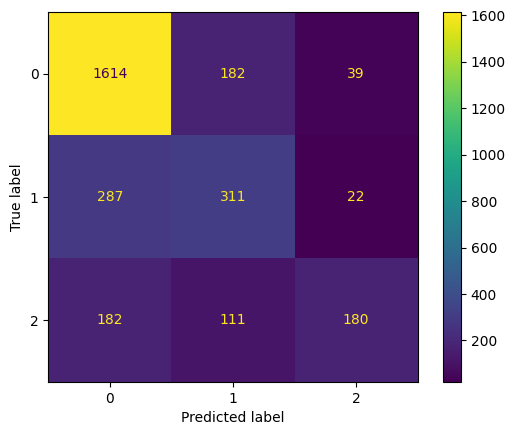

In [ ]:
cm = confusion_matrix(y_test, y_pred_lstm)
disp = ConfusionMatrixDisplay(cm)
disp.plot()

### **Final Comparison Matrix**

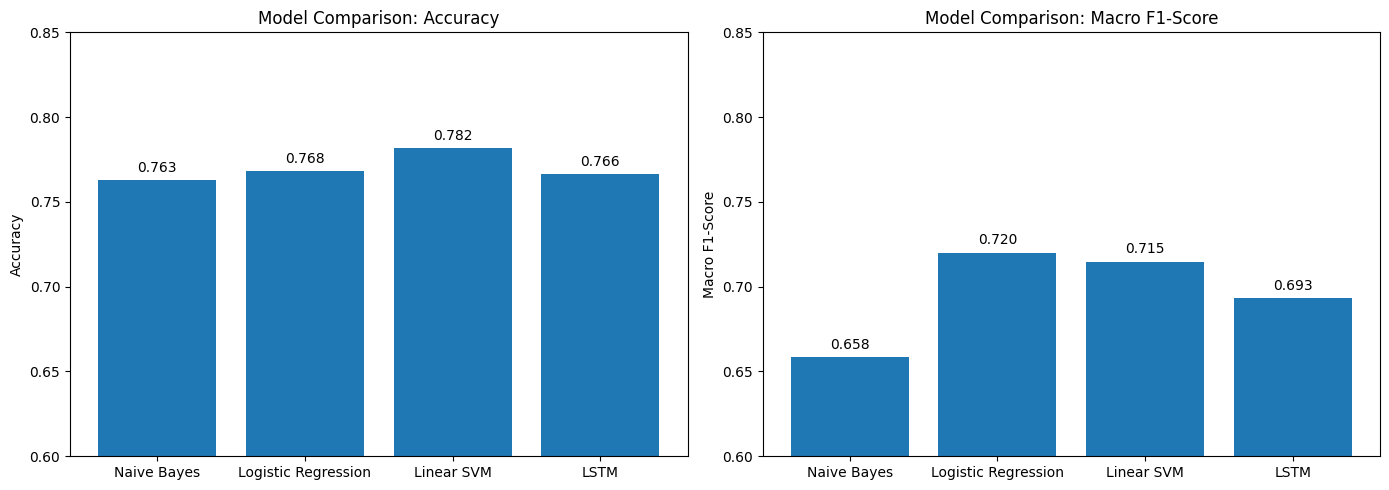

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, f1_score

# Calculate Metrics
acc_nb  = accuracy_score(y_test, y_pred_nb)
acc_lr  = accuracy_score(y_test, y_pred_lr)
acc_svm = accuracy_score(y_test, y_pred_svm)
acc_lstm = accuracy_score(y_test, y_pred_lstm)

f1_nb  = f1_score(y_test, y_pred_nb, average="macro")
f1_lr  = f1_score(y_test, y_pred_lr, average="macro")
f1_svm = f1_score(y_test, y_pred_svm, average="macro")
f1_lstm = f1_score(y_test, y_pred_lstm, average="macro")

models = ["Naive Bayes", "Logistic Regression", "Linear SVM", "LSTM"]

accuracy_scores = [acc_nb, acc_lr, acc_svm, acc_lstm]
f1_scores = [f1_nb, f1_lr, f1_svm, f1_lstm]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy Plot
axes[0].bar(models, accuracy_scores)
axes[0].set_title("Model Comparison: Accuracy")
axes[0].set_ylim(0.6, 0.85)
axes[0].set_ylabel("Accuracy")

for i, v in enumerate(accuracy_scores):
    axes[0].text(i, v + 0.005, f"{v:.3f}", ha="center")

# F1 Plot
axes[1].bar(models, f1_scores)
axes[1].set_title("Model Comparison: Macro F1-Score")
axes[1].set_ylim(0.6, 0.85)
axes[1].set_ylabel("Macro F1-Score")

for i, v in enumerate(f1_scores):
    axes[1].text(i, v + 0.005, f"{v:.3f}", ha="center")

plt.tight_layout()
plt.show()